In [1]:
import pickle
with open(r"/content/drive/MyDrive/GoodReadsClean/IntermediateData/InteractVars/interact.pkl", 'rb') as f:
    int_sparse = pickle.load(f)

In [2]:
int_sparse_rowOG = int_sparse.tocsr().astype(float)

In [3]:
int_sparse_colOG = int_sparse.tocsc().astype(float)

In [4]:
import numpy as np
import scipy.sparse as sc
def concatenate_csr_matrices_by_rows(matrix1, matrix2):
    new_data = np.concatenate((matrix1.data, matrix2.data))
    new_indices = np.concatenate((matrix1.indices, matrix2.indices))
    new_ind_ptr = matrix2.indptr + len(matrix1.data)
    new_ind_ptr = new_ind_ptr[1:]
    new_ind_ptr = np.concatenate((matrix1.indptr, new_ind_ptr))
    ns = (matrix1.shape[0] + matrix2.shape[0], matrix1.shape[1])
    #print(ns)
    return sc.csr_matrix((new_data, new_indices, new_ind_ptr), shape = ns)

## True Similarity

In [6]:
def getTrueSim(id1, id2):
  a = int_sparse_col.getcol(id1)
  b = int_sparse_col.getcol(id2)
  adict = dict(zip(a.indices,a.data))
  bdict = dict(zip(b.indices,b.data))
  inter = list(set(adict.keys()) & set(bdict.keys()))
  if len(inter) <= 1:
    return 0
  bro = np.corrcoef(a[inter].toarray().reshape(1,-1)[0], b[inter].toarray().reshape(1,-1)[0])[0,1]
  return bro

Get idea of distribution of True Similarity

We will use bootstrap to do this - sampling with replacement

In [7]:
import pandas as pd

bk_data = pd.read_pickle("/content/drive/MyDrive/GoodReadsClean/IntermediateData/BooksVars/book_metadata.pkl")

In [8]:
wids = list(set(bk_data["work_id"]))

In [9]:
%%time
samps = 100000
pairs = np.random.choice(wids,samps).reshape((-1,2))
true_sims = []
for cnt,pair in enumerate(pairs):
  if cnt % 10000 == 0:
    print(cnt)
  true_sims.append(getTrueSim(pair[0], pair[1]))

0


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


10000
20000
30000
40000
CPU times: user 11.1 s, sys: 282 ms, total: 11.4 s
Wall time: 11.3 s


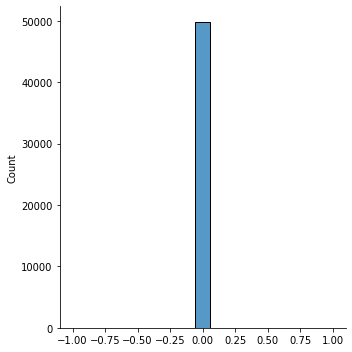

In [10]:
import seaborn as sns
sns.displot(true_sims)

In [12]:
tsims = pd.DataFrame(true_sims)

In [13]:
tsims

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
49995,0.0
49996,0.0
49997,0.0
49998,0.0


In [14]:
tsims.mean()

0    0.000414
dtype: float64

Random sampling shows an average true sim that is miniscule

In [17]:
tsims[tsims[0] != 0].mean()

0    0.232642
dtype: float64

Only 126 books had non-zero similarity, and those averaged true similarity 0.232

## User Similarity

We can use a very similar metric for user similairity

In [93]:
def getTrueSimUser(int_sparse_row, id1, id2):
  a = int_sparse_row.getrow(id1)
  b = int_sparse_row.getrow(id2)
  avals = []
  bvals = []
  adict = dict(zip(a.indices,a.data))
  bdict = dict(zip(b.indices,b.data))
  inter = list(set(adict.keys()) & set(bdict.keys()))
  #print(inter)
  if len(inter) <= 1:
    return 0
  for x in inter:
    avals.append(a.getcol(x).data[0])
    bvals.append(b.getcol(x).data[0])
  #print(avals,bvals, len(avals), len(bvals))
  bro = np.corrcoef(avals,bvals)[0,1]
  return bro

In [94]:
%%time
getTrueSimUser(int_sparse_row, 0,1)

CPU times: user 4.8 ms, sys: 1.07 ms, total: 5.86 ms
Wall time: 4.65 ms


0.5526103928443116

In [68]:
%%time
samps = 100000
pairs = np.random.choice(np.arange(int_sparse_row.shape[0]),samps).reshape((-1,2))
true_sims = []
for cnt,pair in enumerate(pairs):
  if cnt % 10000 == 0:
    print(cnt)
  true_sims.append(getTrueSimUser(pair[0], pair[1]))

0


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


10000
20000
30000
40000
CPU times: user 29.6 s, sys: 11.6 ms, total: 29.6 s
Wall time: 29.6 s


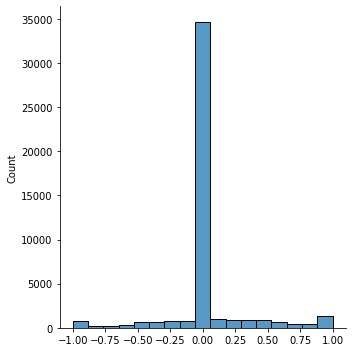

In [69]:
import seaborn as sns
sns.displot(true_sims)

In [73]:
tsims = pd.DataFrame(true_sims)

In [74]:
tsims.mean()

0    0.026522
dtype: float64

Random sampling shows an average true sim that is miniscule

In [77]:
tsims[tsims[0] != 0].mean()

0    0.103452
dtype: float64

Average similarity is interestingly lower than book similarity.

In [104]:
def getSimUsers(id, samp = 10000):
  sims = []
  int_sparse_trunc = int_sparse_col[:,inds]
  for cnt,id2 in enumerate(np.random.choice(np.arange(int_sparse_trunc.shape[0]),samp)):
    s = getTrueSimUser(int_sparse_trunc, id,id2)
    if s != 0:
      sims.append([id2, s])
    if cnt%100 == 0:
      print(cnt)
  return sims

Effective but very slow

## Find Similar Users by filtering

We simply filter our user by those who have read at least some of the books as the current user

In [59]:
def getUserCluster(a,thresh = 0.5):
  histlen = len(a.indices)
  int_sparse_row = int_sparse_rowOG[:,a.indices]
  activeRows = int_sparse_row.getnnz(1)
  sims = activeRows[activeRows>thresh*histlen]
  print(len(sims))
  active = int_sparse_row[sims]
  return active

In [60]:
sims = getUserCluster(int_sparse_rowOG[12093])

5


In [61]:
sims.sum(axis=0)/sims.getnnz(0)

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])

Problem arises that there are very few similar users for some readers, but others have much more

In [65]:
sims = getUserCluster(int_sparse_rowOG[1])

81


In [66]:
sims.sum(axis=0)/sims.getnnz(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


matrix([[4.        ,        nan,        nan,        nan,        nan,
                nan, 4.05714286,        nan,        nan, 5.        ,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
         3.        ,        nan, 3.46875   ,        nan,        nan,
                nan,        nan, 2.        ,        nan,        nan,
                nan, 4.        , 4.        ,        nan,        nan,
                nan, 4.        ,        nan, 4.        , 3.125     ,
         4.        , 5.        ,        nan,        nan, 4.        ,
                nan,        nan,        nan, 4.        , 5.        ,
                nan,        nan, 4.        ,        nan, 4.85      ,
                nan,        nan,        nan,        nan,        nan,
         4.        , 5.        , 4.94444444,        nan,        nan,
         3.4       ,        nan, 4.        , 4.05      , 4.        ,
                nan, 3.        , 2